In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#enable IPython to display matplolib graphs
%matplotlib inline

from sklearn import tree


In [2]:
from ML_classes.DTModel import DTModel


2022-03-15 09:02:10.098096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 09:02:10.098113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
DT = DTModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
DT.DTModel()

DecisionTreeRegressor()

In [7]:
yhat = DT.predict()
yhat

[0.09989118876494812,
 0.06942329059578496,
 0.03438520283688547,
 0.03503808613744554,
 0.3952122148562956,
 0.062023942739378224,
 0.04722524864801872,
 0.058759522993669946,
 0.5288357166717532,
 0.2905331968440954,
 0.0535364549677354,
 0.033514691228987384,
 0.06289445272582236,
 0.05723612970666575,
 0.1038084950541244,
 0.1353645347599776,
 0.19434167957516973,
 0.3858542073694849,
 0.10141458691631419,
 0.24439609297567466,
 0.24766051434283692,
 0.23656149336895377,
 0.09205658915822723,
 0.14515778913274058,
 0.050054410157597026,
 0.046354737040120636,
 0.04113166739273213,
 0.033949947843663404,
 0.036561481045903704,
 0.050924920144041146,
 0.039173015869597955,
 0.07943417003297804,
 0.04526659550343058,
 0.08313384477190838,
 0.0652883592421786,
 0.08073993663409819,
 0.04069641077805611,
 0.12840044189679292,
 0.3560391973652437,
 0.08161044662054232,
 0.03351469285044134,
 0.06354733602638243,
 0.03438520283688547,
 0.1619151266399645,
 0.04918389854969894,
 0.05658324

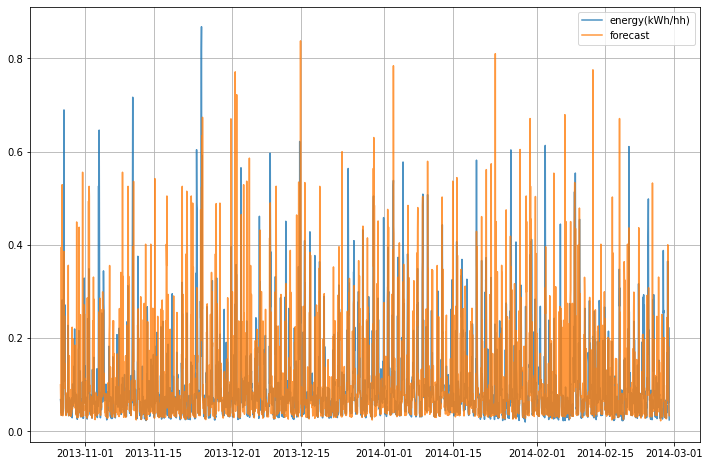

In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = DT.dc.create_X_Y(ts, lag=lag_model)
X = DT.alter_x_shape(X)
# Getting the forecast
yhat = DT.model.predict(X)

yhat = DT.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_12373/276845822.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


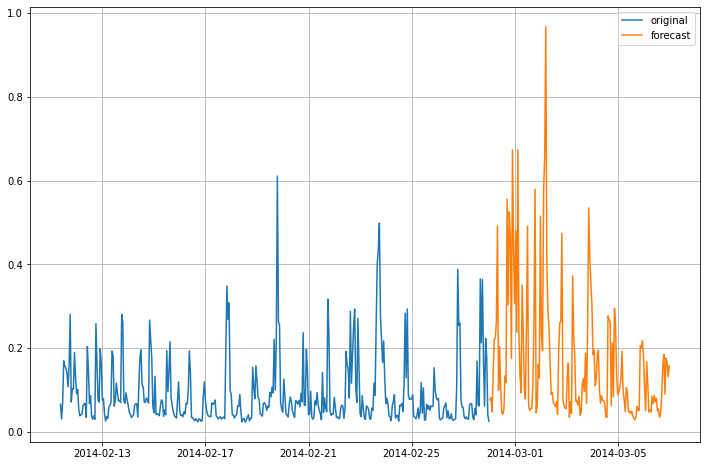

In [9]:
#Forecasting n steps ahead
n_ahead = 168
yhat = DT.predict_n_ahead(n_ahead)
yhat = [y[0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [10]:
DT.evaluateMSE()

0.012534560388255307

In [11]:
DT.evaluateRMSE()

0.111957850945145

In [12]:
DT.evaluateMAE()

0.06446106682741065

In [13]:
DT.evaluateMAPE()

75.19419380019984

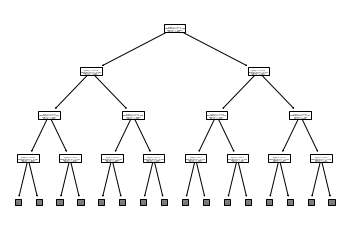

In [14]:
DT.plot_dt()

[Text(0.5, 0.9166666666666666, 'X[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini 

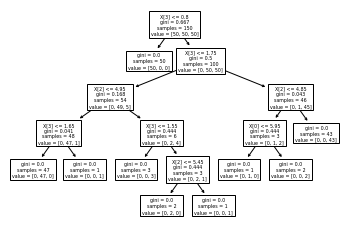

In [15]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

tree.plot_tree(clf)